### Necessary imports

In [19]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
import datetime as dt

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
# import pandas_profiling

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer



%matplotlib inline

### SkLearn Selectors

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class IndexSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select an index only
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.index

### Time-Series Metrics

In [9]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Time-Series Features

In [10]:
ny = [(1, x) for x in range(1, 9)]
fem = [(3, x) for x in range(8, 12)]
male = [(2, x) for x in range(23, 26)]
jun = [(6, x) for x in range(10, 13)]
jun2 = [(6, x) for x in range(15, 17)] # TAT
nov = [(11, x) for x in range(3, 6)] 

shorter_17 = [(2, 22), (3, 7), (8, 29), (8, 31), (11, 3)]
shorter_18 = [(2, 22), (3, 7), (4, 28), (5, 8), (6, 9), (6, 14), (8, 20), (8, 29)]

# Russian 
rus_17 = [(3, 8), (5, 1), (5, 8), (5, 9), (6, 12)] + ny + male + nov
rus_18 = [(1, 7), (5, 9), (4, 28)] + ny + fem + male + jun + jun2 + nov

# Tatartan 
tat_17 = [(6, 25), (8, 30), (9, 1), (11, 6)]
tat_18 = [(11, 6), (8, 30), (8, 21)] + jun2


rus_17 = set([dt.datetime(2017, m, d) for (m, d) in rus_17])
rus_18 = set([dt.datetime(2018, m, d) for (m, d) in rus_18])
tat_17 = set([dt.datetime(2017, m, d) for (m, d) in tat_17])
tat_18 = set([dt.datetime(2018, m, d) for (m, d) in tat_18])
shorter_17 = set([dt.datetime(2017, m, d) for (m, d) in shorter_17])
shorter_18 = set([dt.datetime(2018, m, d) for (m, d) in shorter_18])

class DatetimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, year=True, month=True, day=True, dayofweek=True, 
                 hour=True, minute=True, second=True, russian_holidays=False,
                 weekdays_as_holidays=False, tatar_holidays=False, shortened_day=False, **kwargs):
        self.enc = []
        if year:
            self.enc.append("year")
        if month:
            self.enc.append("month")
        if day:
            self.enc.append("day")
        if dayofweek:
            self.enc.append("dayofweek")
        if hour:
            self.enc.append("hour")
        if minute:
            self.enc.append("minute")
        if second:
            self.enc.append("second")
        
        self.weekdays_as_holidays = weekdays_as_holidays
        self.russian_holidays = russian_holidays
        self.tatar_holidays = tatar_holidays
        self.shortened_day = shortened_day
        
    def _is_tatar_holiday(self, date):
        return date in tat_17 or date in tat_18
    
    def _is_russian_holiday(self, date):
        return date in rus_17 or date in rus_18
    
    def _is_shortened(self, date):
        return date in shorter_17 or date in shorter_18
    
    def fit(self, X, y=None):
        return self

    def transform(self, col):
        result = pd.DataFrame(col)
        
        # Parse weekday holidays
        if self.weekdays_as_holidays:
            result["weekday_holiday"] = result[col.name].apply(lambda date: date.weekday() in [5, 6])
            
        # Parse tatarstan holidays
        if self.tatar_holidays:
            result["tatar_holiday"] = result[col.name].apply(lambda date: self._is_tatar_holiday(date))
            
        # Parse russian holidays
        if self.russian_holidays:
            result["russian_holiday"] = result[col.name].apply(lambda date: self._is_russian_holiday(date))
            
        # Parse shortened days
        if self.shortened_day:
            result["shortened"] = result[col.name].apply(lambda date: self._is_shortened(date))
            
        # Parse datetime
        if len(self.enc) != 0:
            for date_type in self.enc:
                result["{}_{}".format(col.name, date_type)] = getattr(col, date_type)
        
        result.drop([col.name], inplace=True, axis=1)    
        return result

### Time-Series Cross-Validation

In [11]:
from sklearn.model_selection import TimeSeriesSplit

def forecast_cv(model, X, y, loss_function=mean_absolute_percentage_error, folds=3):
    tscv = TimeSeriesSplit(n_splits=folds)
    scores = []
    for train_indices, test_indices, in tscv.split(X, y):
        X_train = X.iloc[train_indices]
        y_train = y.iloc[train_indices]
        
        X_test = X.iloc[test_indices]
        y_test = y.iloc[test_indices]
        
        y_pred = model.fit(X_train, y_train).predict(X_test)
        
        scores.append(loss_function(y_pred, y_test))
        
    return scores

### Contest

In [12]:
data = pd.read_csv("train.csv", encoding="WINDOWS-1251", sep=";",  header=None,
                   names=["date", "calls_in", "calls_proc", "calls_lost", "mean_response_time", "mean_call_time", "mean_operaotrs", "max_operators"])
data.drop(0, inplace=True)
data.set_index("date", inplace=True)
data.index = pd.to_datetime(data.index, dayfirst=True)
data = data.astype(np.int)

In [13]:
def results(models, x, y, folds=9):
    def to_sns_df(l):
        l2 = []
        for mname, maes in l:
             l2.extend([(mname, mae) for mae in maes])
        df = pd.DataFrame(l2)
        df.columns = ["model", "metric"]
        return  df
    
    maes = []
    mapes = []
    for model in models:
        name = model[0]
        pipe = model[1]
        
        results_mae = forecast_cv(pipe, x, y, loss_function=mean_absolute_error, folds=folds)
        results_mape = forecast_cv(pipe, x, y, loss_function=mean_absolute_percentage_error, folds=folds)
        
        print("---")
        print("{}".format(name))
        print("---")
        print("Mean MAE: {}".format(np.mean(results_mae)))
        print("MAE across folds: {}".format(results_mae))
        print("---")
        print("Mean MAPE: {}".format(np.mean(results_mape)))
        print("MAPE across folds: {}".format(results_mape))
        print()
        
        maes.append((name, results_mae))
        mapes.append((name, results_mape))
        
    fig, axes = plt.subplots(2)
    fig.set_size_inches(25, 10)
    sns.boxplot(data = to_sns_df(maes), x= "model", y = "metric", ax=axes[0])
    sns.boxplot(data = to_sns_df(mapes), x= "model", y = "metric", ax=axes[1])

In [14]:
   
# models = [
#     ("naiveLast-Weekday", Pipeline([
#         ("forecaster", NaiveForecasting("last", "weekday"))
#     ])),
#     ("naiveMean-Weekday", Pipeline([
#         ("forecaster", NaiveForecasting("mean", "weekday"))
#     ])),
#     ("naiveMedian-Weekday", Pipeline([
#         ("forecaster", NaiveForecasting("median", "weekday"))
#     ])),
#     ("naiveLast-Monthday", Pipeline([
#         ("forecaster", NaiveForecasting("last", "month"))
#     ])),
#     ("naiveMean-Monthday", Pipeline([
#         ("forecaster", NaiveForecasting("mean", "month"))
#     ])),
#     ("naiveMedian-Monthday", Pipeline([
#         ("forecaster", NaiveForecasting("median", "month"))
#     ])),
#     ("runningAverage-30", Pipeline([
#         ("forecaster", RunningAverageForecasting(window=30))
#     ])),
#     ("LGBM", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer()),
#         ("forecaster", LGBMRegressor())
#     ])),
#     ("LGBM-weekday-day", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True, hour=False, minute=False, second=False)),
#         ("forecaster", LGBMRegressor())
#     ])),
#     ("LGBM-month-weekday-day", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=True, day=True, dayofweek=True, hour=False, minute=False, second=False)),
#         ("forecaster", LGBMRegressor())
#     ])),
#     ("XGBoost", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer()),
#         ("forecaster", XGBRegressor())
#     ])),
#     ("XGBoost-weekday-day", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True, hour=False, minute=False, second=False)),
#         ("forecaster", XGBRegressor())
#     ])),
#     ("XGBoost-weekday-day-russian-tatar-shortened", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
#                                          hour=False, minute=False, second=False, russian_holidays=True,
#                                          tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
#         ("forecaster", XGBRegressor(colsample_bytree=1.0, gamma=0.5, max_depth=4, min_child_weight=1, subsample=0.6))
#     ])),
#     ("XGBoost-month-weekday-day", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=True, day=True, dayofweek=True, hour=False, minute=False, second=False)),
#         ("forecaster", XGBRegressor())
#     ])),
#     ("Linear Regresson", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer()),
#         ("scaler", StandardScaler()),
#         ("forecaster", LinearRegression())
#     ])),
#     ("LinearRegression-weekday-day-russian-tatar-shortened", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
#                                          hour=False, minute=False, second=False, russian_holidays=True,
#                                          tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
#         ("scaler", StandardScaler()),
#         ("forecaster", LinearRegression())
#     ])),
#     ("DecisionTree-weekday-day-russian-tatar-shortened", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
#                                          hour=False, minute=False, second=False, russian_holidays=True,
#                                          tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
#         ("forecaster", DecisionTreeRegressor())
#     ])),
#     ("RandomForest-weekday-day-russian-tatar-shortened", Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
#                                          hour=False, minute=False, second=False, russian_holidays=True,
#                                          tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
#         ("forecaster", RandomForestRegressor())
#     ])),
# ]

# results(models, data, data.calls_in)

In [15]:
# results(models, data, data.calls_lost)

### Testing Area

In [20]:
# predictor = Pipeline([
#         ("selector", IndexSelector()),
#         ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
#                                          hour=False, minute=False, second=False, russian_holidays=True,
#                                          tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
#         ("forecaster", XGBRegressor())
# ])

In [21]:
top_model = Pipeline([
        ("selector", IndexSelector()),
        ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
                                         hour=False, minute=False, second=False, russian_holidays=True,
                                         tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
        ("forecaster", XGBRegressor())
])

In [ ]:
mae = mean_absolute_error(series[window:], rolling_mean[window:])
deviation = np.std(series[window:] - rolling_mean[window:])

lower_bond = rolling_mean - (mae + scale * deviation)
upper_bond = rolling_mean + (mae + scale * deviation)

In [220]:
cb_model =  Pipeline([
        ("selector", IndexSelector()),
        ("features", DatetimeTransformer(year=False, month=False, day=True, dayofweek=True,
                                         hour=False, minute=False, second=False, russian_holidays=True,
                                         tatar_holidays=True, shortened_day=True, weekdays_as_holidays=False)),
        ("bounds", GradientBoostingRegressor(loss='quantile', alpha=0.95,
                                n_estimators=500, max_depth=25,
                                learning_rate=.05, min_samples_leaf=10,
                                min_samples_split=5))
])


def make_json(time, value):
    json_body = [
    {
        "measurement": "calls_in",
#         "tags": {
#             "host": "server01",
#         },
        "time": time,
        "fields": {
            "value": value
        }
    }
    ]
    return json_body

client = InfluxDBClient('localhost', 8086, 'root', 'root', 'example')
for x in data.calls_in.iloc[:-64].iteritems():
    j = make_json(str(x[0]), float(x[1]))
    client.write_points(j)
    

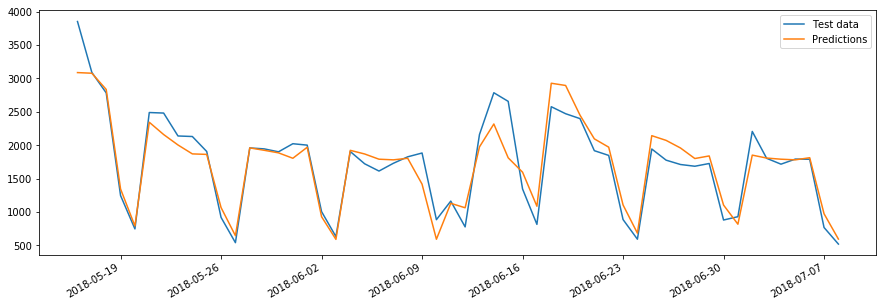

In [250]:
# cb_model.set_params(**best_grid)

out_of_bounds = 0
total = 0
fig, a = plt.subplots()
fig.set_size_inches(15, 5)
for i, (train_indices, test_indices), in enumerate(tscv.split(data, data.calls_in)):
    if i != 7:
        continue
    X_train = data.iloc[train_indices]
    y_train = data.calls_in.iloc[train_indices]

    X_test = data.iloc[test_indices]
    y_test = data.calls_in.iloc[test_indices]

    y_pred = top_model.fit(X_train, y_train).predict(X_test)

    train_residuals = y_train - top_model.predict(X_train)
    train_mae = np.mean(np.abs(train_residuals))


    alpha = 0.99
    # Predict upper
    cb_model.set_params(bounds__alpha=alpha)
    cb_model.fit(X_train, y_train)
    upper_bound = cb_model.predict(X_test)

    # Predict lower
    cb_model.set_params(bounds__alpha= 1 - alpha)
    cb_model.fit(X_train, y_train)
    lower_bound = cb_model.predict(X_test)

    a.plot(y_test, label = "Test data")
    a.plot(pd.Series(y_pred, index=y_test.index), label = "Predictions")
    a.legend()

#     a[i].plot(upper_bound, c = "red", linestyle = ":")
#     a[i].plot(lower_bound, c = "red", linestyle = ":")
    out_of_bounds += np.sum((y_test  < lower_bound - 20) | (y_test > upper_bound + 20))
    total += y_pred.shape[0]

#     aes.append(y_test.values - y_pred)
fig.autofmt_xdate()

# print(out_of_bounds / total)


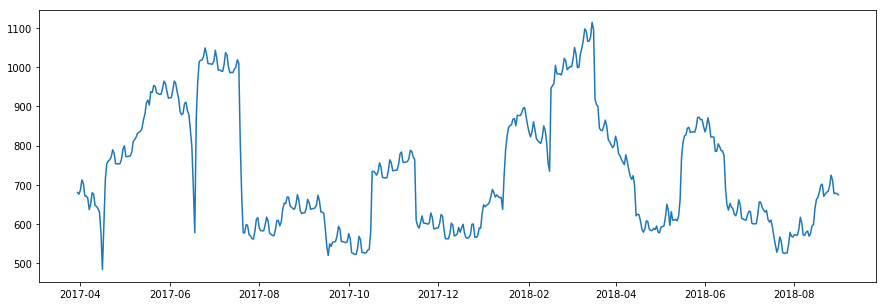

In [165]:
plt.plot(data.calls_in.rolling(30).std())
plt.gcf().set_size_inches(15, 5)

In [47]:
from arch import arch_model
garch11 = arch_model(r, p=1, q=1)
res = garch11.fit(update_freq=10)
print(res.summary())

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.11819846205744461
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.004
Mean Model:             Constant Mean   Adj. R-squared:                 -0.004
Vol Model:                      GARCH   Log-Likelihood:               0.118198
Distribution:                  Normal   AIC:                           7.76360
Method:            Maximum Likelihood   BIC:                           10.5958
                                        No. Observations:                   15
Date:                Sat, Nov 10 2018   Df Residuals:                       11
Time:                        19:59:30   Df Model:                            4
                               Mean Model                               
     

In [23]:
# # A parameter grid for XGBoost
# params = {
#     'forecaster__min_child_weight': [1, 5, 10],
#     'forecaster__gamma': [0.5, 1, 1.5, 2, 5],
#     'forecaster__subsample': [0.6, 0.8, 1.0],
#     'forecaster__colsample_bytree': [0.6, 0.8, 1.0],
#     'forecaster__max_depth': [3, 4, 8, 16, 32, 64, 128]
# }

# tscv = TimeSeriesSplit(n_splits=9)
# random_search = GridSearchCV(top_model, params, 
#                                    scoring=make_scorer(mean_absolute_percentage_error, greater_is_better=False),
#                                    cv=tscv.split(data, data.calls_in), verbose=2)
# random_search.fit(data, data.calls_in)

In [61]:
# In[1]:

import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
import arch

# In[2]:

df = pd.DataFrame()
df['pct_change'] = data.calls_in.diff()
df.dropna(inplace=True)
df.head()

,pct_change
date,
2017-03-02,-361.0
2017-03-03,4.0
2017-03-04,-712.0
2017-03-05,-501.0
2017-03-06,1278.0


In [62]:
df['stdev21'] = df['pct_change'].rolling(window=7, center=False).std()
df = df.dropna() # Remove rows with blank cells.
df.head()

,pct_change,stdev21
date,,
2017-03-08,-1482.0,865.883914
2017-03-09,1289.0,1027.554981
2017-03-10,-5.0,1027.591683
2017-03-11,-883.0,1049.797101
2017-03-12,-416.0,1043.514848


In [63]:
returns = df['pct_change'] 
am = arch.arch_model(returns)
res = am.fit(disp='off')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             pct_change   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -4386.76
Distribution:                  Normal   AIC:                           8781.53
Method:            Maximum Likelihood   BIC:                           8798.71
                                        No. Observations:                  542
Date:                Sat, Nov 10 2018   Df Residuals:                      538
Time:                        20:12:52   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             2.8266     37.842  7.469e-02      0.940 [-71.342, 76.995]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.8840e+05  5.574e+05      0.338      0.735 [-9.042e+05,1.281e+06]
alpha[1]   4.2208e-03  2.057e-02      0.205      0.837 [-3.609e-02,4.453e-02]
beta[1]        0.6943      0.882      0.787      0.431      [ -1.035,  2.424]
=============================================================================

Covariance estimator: robust
"""

In [64]:
df['forecast_vol'] = 0.1 * np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]'])

df.tail()

,pct_change,stdev21,forecast_vol
date,,,
2018-08-27,1646.0,884.316389,79.502043
2018-08-28,-200.0,840.208789,79.208498
2018-08-29,-76.0,819.591739,78.994722
2018-08-30,-610.0,848.630269,78.944756
2018-08-31,874.0,926.499403,79.012514


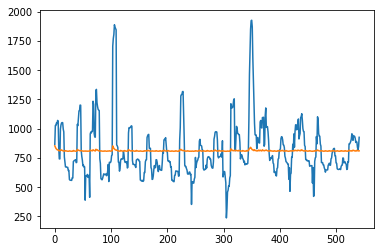

In [85]:
plt.plot(df.stdev21.values)
keke = (np.mean(df.stdev21 / df.forecast_vol) * df.forecast_vol).values
plt.plot(keke)

In [87]:
import time
import datetime
d = datetime.date(2015,1,5)

unixtime = time.mktime(d.timetuple())

In [88]:
unixtime

1420405200.0

In [107]:
import numpy as np
from scipy.stats import binom_test

from sklearn.base import BaseEstimator, RegressorMixin
from xgboost.sklearn import XGBRegressor
from functools import partial

class XGBOOSTQUANTILE(BaseEstimator, RegressorMixin):
    def __init__(self, quant_alpha,quant_delta,quant_thres,quant_var,
                n_estimators = 100,max_depth = 3,reg_alpha = 5.,reg_lambda=1.0,gamma=0.5):
        self.quant_alpha = quant_alpha
        self.quant_delta = quant_delta
        self.quant_thres = quant_thres
        self.quant_var = quant_var
        #xgboost parameters
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.reg_alpha= reg_alpha
        self.reg_lambda = reg_lambda
        self.gamma = gamma

        #keep xgboost estimator in memory

        self.clf = None

    def fit(self, X, y):

        def quantile_loss(y_true, y_pred,_alpha,_delta,_threshold,_var):
            x = y_true - y_pred
            grad = (x==(_alpha-1.0)*_delta)&(x_alpha*_delta)
            hess = ((x>=(_alpha-1.0)*_delta)& (x<_alpha*_delta) )/_delta

            _len = np.array([y_true]).size

            var = (2*np.random.randint(2, size=_len)-1.0)*_var
            grad = (np.abs(x) == _threshold )*var
            hess = (np.abs(x) == _threshold )
            return grad, hess

        self.clf = XGBRegressor(objective=partial( quantile_loss,
                                            _alpha=self.quant_alpha,
                                            _delta = self.quant_delta,
                                            _threshold = self.quant_thres,
                                            _var = self.quant_var),
                                  n_estimators = self.n_estimators,
                                  max_depth = self.max_depth, 
                                  reg_alpha =self.reg_alpha,
                                  reg_lambda = self.reg_lambda,
                                  gamma = self.gamma )

        self.clf.fit(X,y)
        return self

    def predict(self, X):
        y_pred = self.clf.predict(X)
        return y_pred

    def score(self, X, y):
        y_pred = self.clf.predict(X)
        score = (self.quant_alpha-1.0)*(y-y_pred)*(y==y_pred)
        score = 1./np.sum(score)
        return score

In [110]:
import numpy as np

np.random.seed(1)
def f(x):
    """The function to predict."""
    return x *np.sin(x)

#----------------------------------------------------------------------
# First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()
dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)

In [111]:
model = XGBOOSTQUANTILE(95,)

TypeError: __init__() missing 3 required positional arguments: 'quant_delta', 'quant_thres', and 'quant_var'

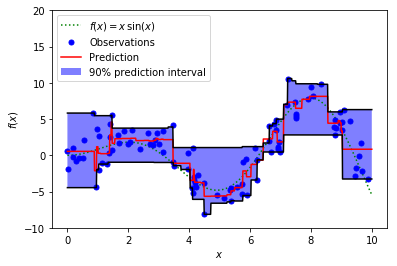

In [112]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

#----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d(np.random.uniform(0, 10.0, size=100)).T
X = X.astype(np.float32)

# Observations
y = f(X).ravel()

dy = 1.5 + 1.0 * np.random.random(y.shape)
noise = np.random.normal(0, dy)
y += noise
y = y.astype(np.float32)



clf = GradientBoostingRegressor(loss='quantile', alpha=0.95,
                                n_estimators=250, max_depth=3,
                                learning_rate=.1, min_samples_leaf=9,
                                min_samples_split=9)

clf.fit(X, y)


# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
xx = np.atleast_2d(np.linspace(0, 10, 1000)).T
xx = xx.astype(np.float32)

# Make the prediction on the meshed x-axis
y_upper = clf.predict(xx)

clf.set_params(alpha=1.0 - alpha)
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_lower = clf.predict(xx)

clf.set_params(loss='ls')
clf.fit(X, y)

# Make the prediction on the meshed x-axis
y_pred = clf.predict(xx)

# Plot the function, the prediction and the 90% confidence interval based on
# the MSE
fig = plt.figure()
plt.plot(xx, f(xx), 'g:', label=u'$f(x) = x\,\sin(x)$')
plt.plot(X, y, 'b.', markersize=10, label=u'Observations')
plt.plot(xx, y_pred, 'r-', label=u'Prediction')
plt.plot(xx, y_upper, 'k-')
plt.plot(xx, y_lower, 'k-')

plt.fill(np.concatenate([xx, xx[::-1]]),
         np.concatenate([y_upper, y_lower[::-1]]),
         alpha=.5, fc='b', ec='None', label='90% prediction interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-10, 20)
plt.legend(loc='upper left')
plt.show()

In [236]:
results = list(client.query("SELECT * FROM calls_in"))[0]
len(results)

61

In [ ]:
client.query()

In [222]:
from influxdb import InfluxDBClient
client = InfluxDBClient('localhost', 8086, 'root', 'root', 'example')
results = list(client.query("SELECT * FROM calls_in"))[0]
X = pd.DataFrame([(x['time'], x['value']) for x in results])
X[0] = pd.to_datetime(X[0])
X.set_index(0, inplace=True)

In [226]:
top_model.fit(X, X[1].values)

Pipeline(memory=None,
     steps=[('selector', IndexSelector()), ('features', DatetimeTransformer(day=None, dayofweek=None, hour=None, minute=None,
          month=None, russian_holidays=True, second=None,
          shortened_day=True, tatar_holidays=True,
          weekdays_as_holidays=False, year=None)), ('forecaster', XGBR...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [234]:
dummy_series = pd.Series([0])
dummy_series.index = (pd.to_datetime([datetime.datetime.now()]))
dummy_series

2018-11-11 12:24:14.765495    0
dtype: int64

In [227]:
top_model.predict()

AttributeError: 'datetime.datetime' object has no attribute 'index'